# Face Detection

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import cv2
import random
import pprint
import math
import scipy.io
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import tensorflow as tf

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.objectives import categorical_crossentropy

%matplotlib inline
plt.rcParams["axes.grid"] = False

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

working_dir = '/content/gdrive/My Drive/CS175'
sys.path.insert(0, working_dir)


# working_dir = '.'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from frcnn.RoiPoolingConv import RoiPoolingConv
import frcnn.roi_helpers as roi_helpers
from frcnn import config, data_generators

## Config

In [0]:
C = config.Config()
C.use_horizontal_flips = True
C.use_vertical_flips = True
C.rot_90 = True
C.num_rois = 32
C.network = 'vgg'
# C.data_path = './wider_faces'
# C.data_path = './VOCdevkit'
C.net_weights = working_dir + "/model_weights.h5"
C.base_net_weights = working_dir + "/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

C.is_training = False
C.is_testing = True

## Download Dataset

In [5]:
data_dir       = working_dir + "/dataset"

train_dir      = f"{data_dir}/WIDER_train"
val_dir        = f"{data_dir}/WIDER_val"
test_dir       = f"{data_dir}/WIDER_test"
face_split_dir = f"{data_dir}/wider_face_split"

if not os.path.exists(train_dir + '.zip'):
  ! wget -P "$train_dir".zip https://abcdapp.net/datasets/wider/WIDER_train.zip
if not os.path.exists(train_dir):
  ! unzip -q "$train_dir".zip/* -d "$data_dir"

# if not os.path.exists(val_dir + '.zip'):
#   ! wget -P "$val_dir".zip https://abcdapp.net/datasets/wider/WIDER_val.zip
# if not os.path.exists(val_dir):
#   ! unzip -q "$val_dir".zip -d "$data_dir"

# if C.is_testing and not os.path.exists(test_dir + '.zip'):
#   ! wget -P "$test_dir".zip https://abcdapp.net/datasets/wider/WIDER_test.zip
# if not os.path.exists(test_dir):
#   ! unzip -q "$test_dir".zip -d "$data_dir"

if not os.path.exists(face_split_dir + '.zip'):
  ! wget -P "$face_split_dir".zip https://abcdapp.net/datasets/wider/wider_face_split.zip
if not os.path.exists(face_split_dir):
  ! unzip -q "$face_split_dir".zip/* -d "$data_dir"
  
print("Dataset is ready to use.")

Dataset is ready to use.


## Download Weights
Pretrained Weights for base model VGG16   ( keras.application.vgg16 already handles downloading the weights file so we can try to update this code to use it)

In [6]:
if not os.path.exists(C.base_net_weights):
  ! wget https://abcdapp.net/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5
  C.base_net_weights = working_dir + "/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

print("Weight file is ready to use.")

Weight file is ready to use.


## Data Processing

In [0]:
def get_wider_data(data_dir, label_mat_file):
  train_data = []
  classes_count = { 'face': 0 }
  class_mapping = { 'face': 0 }
  mat = scipy.io.loadmat(label_mat_file)

  for i in range(len(mat['event_list'])):
    event = mat['event_list'][i, 0][0]
    for j in range(len(mat['file_list'][i, 0])):
      file = mat['file_list'][i, 0][j, 0][0]
      filename = "{}.jpg".format(file)
      file_path = os.path.join(data_dir, 'images', event, filename)

      # bounding boxes and labels of the picture file
      boxes = mat['face_bbx_list'][i, 0][j, 0]

      img_b_boxes = []
      for box in boxes:
        classes_count['face'] += 1
        img_b_boxes.append({
            "x1": box[0],
            "x2": box[0] + box[2],
            "y1": box[1],
            "y2": box[1] + box[3],
            "w": box[2],
            "h": box[3],
            "class": "face",
            "difficult": False
        })

      image = mpimg.imread(file_path)

      width, height, channels = image.shape

      train_data.append({
          "bboxes": img_b_boxes,
          "filepath": file_path,
          'imageset': 'trainval',
          'height': height,
          'width': width
      })

  return train_data, classes_count, class_mapping

- Load file paths and border boxes from annotation files
- Read all images to get image width and height since it is not available in the annotation files
- Save everything to a single file so we can load it faster next time

In [8]:
if os.path.isfile(working_dir + "/wider_data.pickle"):
  with open(working_dir + "/wider_data.pickle", 'rb') as wider_data:
    all_images, classes_count, class_mapping = pickle.load(wider_data)
else:
  all_images, classes_count, class_mapping = get_wider_data(train_dir, face_split_dir + "/wider_face_train.mat")
  with open(working_dir + "/wider_data.pickle", 'wb') as wider_data:
    pickle.dump([all_images, classes_count, class_mapping], wider_data)

if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)
    
print('Training images per class:', classes_count)

print('Num classes (including bg) =', len(classes_count))

Training images per class: {'face': 159424, 'bg': 0}
Num classes (including bg) = 2


## Save Config

In [9]:
C.class_mapping = class_mapping

config_output_filename = "config.dat"

with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C, config_f)
    print("Config has been written to,", config_output_filename,
          ", and can be loaded when testing to ensure correct results")

Config has been written to, config.dat , and can be loaded when testing to ensure correct results


## Data generator

In [0]:
if C.is_training:
  random.shuffle(all_images)

  num_imgs = len(all_images)

  def get_img_output_length(width, height):
      def get_output_length(input_length):
          return input_length//16
      return get_output_length(width), get_output_length(height)  

  data_gen_train = data_generators.get_anchor_gt(all_images, classes_count, C, 
                     get_img_output_length, K.image_dim_ordering(), mode='train')

## Base CNN Model

In [0]:
def get_weight_path():
    if K.image_dim_ordering() == 'th':
        print('pretrained weights not available for VGG with theano backend')
        return
    else:
        return 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'

def nn_base(input_tensor=None, trainable=False):
    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        input_shape = (3, None, None)
    else:
        input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

def rpn(base_layers, num_anchors):
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)
    return [x_class, x_regr, base_layers]

def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):
    # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround
    if K.backend() == 'tensorflow':
        pooling_regions = 7
        input_shape = (num_rois,7,7,512)
    elif K.backend() == 'theano':
        pooling_regions = 7
        input_shape = (num_rois,512,7,7)
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
    return [out_class, out_regr]

## Loss Functions

In [0]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0
lambda_cls_regr = 1.0
lambda_cls_class = 1.0
epsilon = 1e-4


def rpn_loss_regr(num_anchors):
	def rpn_loss_regr_fixed_num(y_true, y_pred):
		if K.image_dim_ordering() == 'th':
			x = y_true[:, 4 * num_anchors:, :, :] - y_pred
			x_abs = K.abs(x)
			x_bool = K.less_equal(x_abs, 1.0)
			return lambda_rpn_regr * K.sum(
				y_true[:, :4 * num_anchors, :, :] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :4 * num_anchors, :, :])
		else:
			x = y_true[:, :, :, 4 * num_anchors:] - y_pred
			x_abs = K.abs(x)
			x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

			return lambda_rpn_regr * K.sum(
				y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

	return rpn_loss_regr_fixed_num


def rpn_loss_cls(num_anchors):
	def rpn_loss_cls_fixed_num(y_true, y_pred):
		if K.image_dim_ordering() == 'tf':
			return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])
		else:
			return lambda_rpn_class * K.sum(y_true[:, :num_anchors, :, :] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, num_anchors:, :, :])) / K.sum(epsilon + y_true[:, :num_anchors, :, :])

	return rpn_loss_cls_fixed_num


def class_loss_regr(num_classes):
	def class_loss_regr_fixed_num(y_true, y_pred):
		x = y_true[:, :, 4*num_classes:] - y_pred
		x_abs = K.abs(x)
		x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
		return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
	return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
	return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))


## Detection Models

In [0]:
if C.is_training:
  
  if K.image_dim_ordering() == 'th':
      input_shape_img = (3, None, None)
  else:
      input_shape_img = (None, None, 3)

  img_input = Input(shape=input_shape_img)
  roi_input = Input(shape=(None, 4))
  
  # define the base network (resnet here, can be VGG, Inception, etc)
  shared_layers = nn_base(img_input, trainable=True)

  # define the RPN, built on the base layers
  num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
  rpn = rpn(shared_layers, num_anchors)

  classifier = classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

  model_rpn = Model(img_input, rpn[:2])
  model_classifier = Model([img_input, roi_input], classifier)

  # this is a model that holds both the RPN and the classifier, used to load/save weights for the models
  model_all = Model([img_input, roi_input], rpn[:2] + classifier)

## Load Weights
- First time we run the trainer we load the base weights from VGG16 model.
- Face detection model also has a seperate weight file.
- After each epoch if the loss is less than the last loss we update the waight file.

In [0]:
if C.is_training:
  
  if os.path.exists(C.net_weights):
    print('Loading weights from {}'.format(C.net_weights))
    model_rpn.load_weights(C.net_weights, by_name=True)
    model_classifier.load_weights(C.net_weights, by_name=True)
  elif os.path.exists(C.base_net_weights):
    print('loading weights from {}'.format(C.base_net_weights))
    model_rpn.load_weights(C.base_net_weights, by_name=True)
    model_classifier.load_weights(C.base_net_weights, by_name=True)
  else:
    print('Could not load any pretrained model weights!')

## Compile Model

In [0]:
if C.is_training:
  
  model_rpn.compile(optimizer=Adam(lr=1e-5), 
    loss=[rpn_loss_cls(num_anchors), rpn_loss_regr(num_anchors)])

  model_classifier.compile(optimizer=Adam(lr=1e-5),
    loss=[class_loss_cls, class_loss_regr(len(classes_count) - 1)],
    metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})

  model_all.compile(optimizer='sgd', loss='mae')
  
  best_loss = np.Inf
  epoch_length = 500
  num_epochs = 10
  iter_num = 0

  losses = np.zeros((epoch_length, 5))
  rpn_accuracy_rpn_monitor = []
  rpn_accuracy_for_epoch = []
  start_time = time.time()

## Train

In [0]:
if C.is_training:

  print('Starting training')

  for epoch_num in range(num_epochs):

      progbar = generic_utils.Progbar(epoch_length)
      print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

      while True:
        try:

          if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
            mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor)) / len(rpn_accuracy_rpn_monitor)
            rpn_accuracy_rpn_monitor = []
            print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(
              mean_overlapping_bboxes, epoch_length))
            if mean_overlapping_bboxes == 0:
              print('RPN is not producing bounding boxes that overlap the ground truth boxes.',
                      'Check RPN settings or keep training.')

          X, Y, img_data = next(data_gen_train)

          loss_rpn = model_rpn.train_on_batch(X, Y)

          P_rpn = model_rpn.predict_on_batch(X)

          R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True,
                                     overlap_thresh=0.7, max_boxes=300)

          # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
          X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

          if X2 is None:
            rpn_accuracy_rpn_monitor.append(0)
            rpn_accuracy_for_epoch.append(0)
            continue

          neg_samples = np.where(Y1[0, :, -1] == 1)
          pos_samples = np.where(Y1[0, :, -1] == 0)

          if len(neg_samples) > 0:
            neg_samples = neg_samples[0]
          else:
            neg_samples = []

          if len(pos_samples) > 0:
            pos_samples = pos_samples[0]
          else:
            pos_samples = []

          rpn_accuracy_rpn_monitor.append(len(pos_samples))
          rpn_accuracy_for_epoch.append((len(pos_samples)))

          if C.num_rois > 1:
            if len(pos_samples) < C.num_rois // 2:
              selected_pos_samples = pos_samples.tolist()
            else:
              selected_pos_samples = np.random.choice(pos_samples, C.num_rois // 2, replace=False).tolist()
            try:
              selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples),
                                                          replace=False).tolist()
            except:
              selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples),
                                                          replace=True).tolist()

            sel_samples = selected_pos_samples + selected_neg_samples
          else:
            # in the extreme case where num_rois = 1, we pick a random pos or neg sample
            selected_pos_samples = pos_samples.tolist()
            selected_neg_samples = neg_samples.tolist()
            if np.random.randint(0, 2):
              sel_samples = random.choice(neg_samples)
            else:
              sel_samples = random.choice(pos_samples)

          loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]],
                                                       [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

          losses[iter_num, 0] = loss_rpn[1]
          losses[iter_num, 1] = loss_rpn[2]

          losses[iter_num, 2] = loss_class[1]
          losses[iter_num, 3] = loss_class[2]
          losses[iter_num, 4] = loss_class[3]

          iter_num += 1

          progbar.update(iter_num,
                         [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                          ('detector_cls', np.mean(losses[:iter_num, 2])),
                          ('detector_regr', np.mean(losses[:iter_num, 3]))])

          if iter_num == epoch_length:
            loss_rpn_cls = np.mean(losses[:, 0])
            loss_rpn_regr = np.mean(losses[:, 1])
            loss_class_cls = np.mean(losses[:, 2])
            loss_class_regr = np.mean(losses[:, 3])
            class_acc = np.mean(losses[:, 4])
            mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
            rpn_accuracy_for_epoch = []
            if C.verbose:
              print('Mean number of bounding boxes from RPN overlapping ground truth boxes:', mean_overlapping_bboxes)
              print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
              print('Loss RPN classifier: {}'.format(loss_rpn_cls))
              print('Loss RPN regression: {}'.format(loss_rpn_regr))
              print('Loss Detector classifier: {}'.format(loss_class_cls))
              print('Loss Detector regression: {}'.format(loss_class_regr))
              print('Elapsed time: {}'.format(time.time() - start_time))
            curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
            iter_num = 0
            start_time = time.time()
            if curr_loss < best_loss:
              if C.verbose:
                print('Total loss decreased from {} to {}, saving weights'.format(best_loss, curr_loss))
              best_loss = curr_loss
              model_all.save_weights(C.net_weights)
            break

        except Exception as e:
          print('\nException: {}\n\n'.format(e))
          continue

  print('Training complete, exiting.')

# Test

In [0]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

In [0]:
def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

In [0]:
def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

In [0]:
# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):
	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))
	return (real_x1, real_y1, real_x2 ,real_y2)

In [21]:
if C.is_testing:

  if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

  class_mapping = {v: k for k, v in class_mapping.items()}
  print(class_mapping)
  class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

  num_features = 512

  if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
  else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


  img_input = Input(shape=input_shape_img)
  roi_input = Input(shape=(C.num_rois, 4))
  feature_map_input = Input(shape=input_shape_features)
  
  # define the base network
  shared_layers = nn_base(img_input, trainable=True)

  # define the RPN, built on the base layers
  num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
  rpn_layers = rpn(shared_layers, num_anchors)

  classifier = classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

  model_rpn = Model(img_input, rpn_layers)
  model_classifier_only = Model([feature_map_input, roi_input], classifier)

  model_classifier = Model([feature_map_input, roi_input], classifier)

{0: 'face', 1: 'bg'}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
if C.is_testing:
  
  print('Loading weights from {}'.format(C.net_weights))
  model_rpn.load_weights(C.net_weights, by_name=True)
  model_classifier.load_weights(C.net_weights, by_name=True)

Loading weights from /content/gdrive/My Drive/CS175/model_weights.h5


In [0]:
if C.is_testing:

  model_rpn.compile(optimizer='sgd', loss='mse')
  model_classifier.compile(optimizer='sgd', loss='mse')

In [0]:
def draw_bboxs(ax, bboxs, scores, color):
  # If color not provided set color based on the score
  for k, bbox in enumerate(bboxs):
    if not color and score:
      color = (255,int(255*2*(1-score[k])),0)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

In [0]:
def detect_faces(img, ax, threshold = 0.8):
  
  st = time.time()
  ax.imshow(img)

  X, ratio = format_img(img, C)

  if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))

  # get the feature maps and output from the RPN
  [Y1, Y2, F] = model_rpn.predict(X)

  R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

  # convert from (x1,y1,x2,y2) to (x,y,w,h)
  R[:, 2] -= R[:, 0]
  R[:, 3] -= R[:, 1]

  # apply the spatial pyramid pooling to the proposed regions
  bboxes = {}
  probs = {}

  for jk in range(R.shape[0] // C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
    if ROIs.shape[1] == 0:
      break

    if jk == R.shape[0] // C.num_rois:
      # pad R
      curr_shape = ROIs.shape
      target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
      ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
      ROIs_padded[:, :curr_shape[1], :] = ROIs
      ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
      ROIs = ROIs_padded

    [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

    for ii in range(P_cls.shape[1]):
      if np.max(P_cls[0, ii, :]) < threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
        continue
      cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

      if cls_name not in bboxes:
        bboxes[cls_name] = []
        probs[cls_name] = []

      (x, y, w, h) = ROIs[0, ii, :]

      cls_num = np.argmax(P_cls[0, ii, :])
      try:
        (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
        tx /= C.classifier_regr_std[0]
        ty /= C.classifier_regr_std[1]
        tw /= C.classifier_regr_std[2]
        th /= C.classifier_regr_std[3]
        x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
      except:
        pass
      bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)])
      probs[cls_name].append(np.max(P_cls[0, ii, :]))

  all_dets = []
  
  for key in bboxes:
    bbox = np.array(bboxes[key])
    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
    for jk in range(new_boxes.shape[0]):
      (x1, y1, x2, y2) = new_boxes[jk, :]

      (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

      ax.add_patch(patches.Rectangle((real_x1, real_y1), real_x2-real_x1, real_y2-real_y1,
                               linewidth=1, edgecolor=(0, 1, 0), facecolor='none'))

      text = '{}: {}'.format(key, int(100 * new_probs[jk]))
      ax.text(real_x1, real_y1, text, fontsize=9, 
              bbox=dict(facecolor='green', alpha=0.8), color='white')

  print('Elapsed time = {}'.format(time.time() - st))
  plt.show()

#### Put some images in the test folder to see the detection result

6_Funeral_Funeral_6_211.jpg
Elapsed time = 5.614426374435425


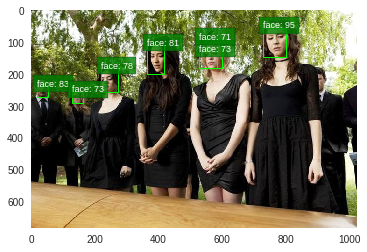

6_Funeral_Funeral_6_241.jpg
Elapsed time = 4.1576828956604


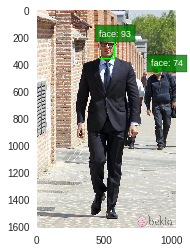

6_Funeral_Funeral_6_252.jpg
Elapsed time = 3.8167340755462646


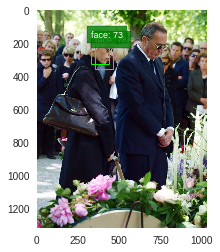

6_Funeral_Funeral_6_292.jpg
Elapsed time = 5.0132646560668945


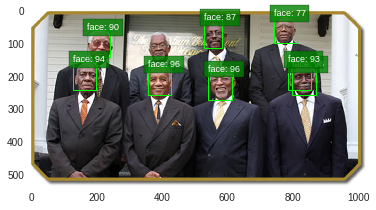

6_Funeral_Funeral_6_315.jpg
Elapsed time = 4.099971055984497


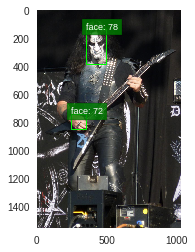

6_Funeral_Funeral_6_364.jpg
Elapsed time = 3.7498857975006104


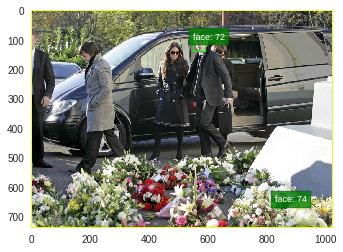

6_Funeral_Funeral_6_432.jpg
Elapsed time = 4.084237813949585


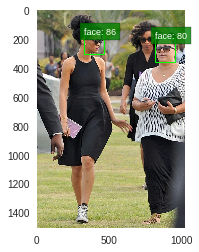

6_Funeral_Funeral_6_444.jpg
Elapsed time = 3.1752805709838867


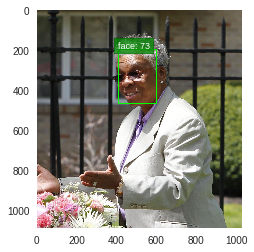

6_Funeral_Funeral_6_461.jpg
Elapsed time = 3.6864471435546875


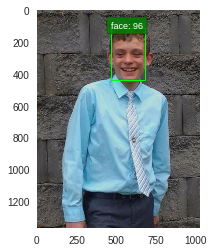

6_Funeral_Funeral_6_483.jpg
Elapsed time = 3.8261399269104004


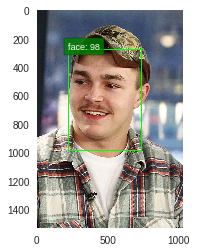

6_Funeral_Funeral_6_485.jpg
Elapsed time = 4.921544790267944


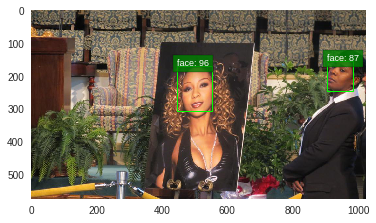

6_Funeral_Funeral_6_531.jpg
Elapsed time = 0.9707279205322266


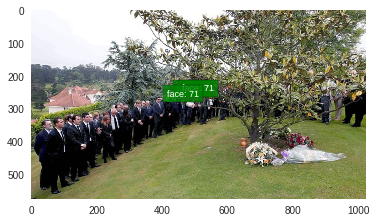

6_Funeral_Funeral_6_537.jpg
Elapsed time = 3.802138328552246


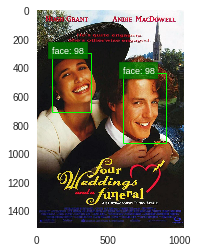

In [26]:
if C.is_testing:

  test_images_dir = working_dir + '/test'
  
  test_images = os.listdir(test_images_dir)

  for idx, img_name in enumerate(sorted(test_images)):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
      continue

    print(img_name)

    fig, ax = plt.subplots(1)

    img = mpimg.imread(os.path.join(test_images_dir, img_name))

    detect_faces(img, ax, threshold=0.7)
  

## Test Camera
- Run this cell on a local machine to test live face detection

In [0]:
# # Run this cell on a local runtime

# import os
# import cv2
# import time

# # Display from webcam
# cap = cv2.VideoCapture(0)

# # Display from local file
# # cap = cv2.VideoCapture('/Users/sami/Downloads/BS/Blindspot.mkv')

# while cap.isOpened():
#   # time.sleep(0.5)  # Simulate possible prediction delays in seconds
  
#   ret, frame = cap.read()

# #   gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# #   faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# #   for (x,y,w,h) in faces:
# #       cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
#   fig, ax = plt.subplots(1)

#   test_face_detection(img, ax, threshold=0.7)

#   cv2.imshow('image', frame)
  
#   if cv2.waitKey(10) & 0xFF == ord('q'):
#       break

# cap.release()
# cv2.destroyAllWindows()